# Проект Дашборд конверсий

In [1]:
import requests
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sea
import matplotlib.colors as matcol
from dotenv import load_dotenv
from pathlib import Path

### Запрашиваем данные по API

In [3]:
load_dotenv()
DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')
API_URL = os.getenv('API_URL')

resp_v = rq.get(f"{API_URL}/visits?begin={DATE_BEGIN}&end={DATE_END}")
visits_json = resp_v.json()
resp_r = rq.get(f"{API_URL}/registrations?begin={DATE_BEGIN}&end={DATE_END}")
registrations_json = resp_r.json()

## Рассчитываем метрики

#### Проведем обработку и группировку данных по визитам

In [8]:
# Преобразовываем данные JSON в DataFrame
visits = pd.DataFrame(visits_json)

# Преобразуем даты и отберем только последний визит для каждого visit_id
visits['datetime'] = pd.to_datetime(visits['datetime'])
filter_visits = visits.loc[visits.groupby('visit_id')['datetime'].idxmax()].copy()
filter_visits['date_group'] = filter_visits['datetime'].dt.date

# Отмечаем ботов и исключаем их
filter_visits = filter_visits[~filter_visits['user_agent'].str.contains('bot', case=False)]

# Группируем данные визитов по датам и платформам
visit_grouped = filter_visits.groupby(['date_group', 'platform']).size().reset_index(name='visits').sort_values(by='date_group')

visit_grouped.head(6)

,date_group,platform,visits
0,2023-03-01,android,75
1,2023-03-01,ios,22
2,2023-03-01,web,279
3,2023-03-02,android,67
4,2023-03-02,ios,31
5,2023-03-02,web,515


#### Проведем обработку и группировку данных по регистрациям

In [9]:
# Преобразовываем данные JSON в DataFrame
registrations = pd.DataFrame(registrations_json)

# Преобразуем даты
registrations['date_group'] = pd.to_datetime(registrations['datetime']).dt.date

# Группируем данные регистрации по датам и платформам
reg_grouped = registrations.groupby(['date_group', 'platform']).size().reset_index(name='registrations').sort_values(by='date_group')

reg_grouped.head(6)

,date_group,platform,registrations
0,2023-03-01,android,61
1,2023-03-01,ios,18
2,2023-03-01,web,8
3,2023-03-02,android,59
4,2023-03-02,ios,24
5,2023-03-02,web,23


#### Объединим датайфреймы, сделаем итоговый датафрейм с расчетом конверсии, сохраним в формате JSON

In [10]:
# Объединим датайфреймы и посчитаем конверсию
conversion = pd.merge(visit_grouped, reg_grouped, on=['date_group', 'platform'], how='outer')
conversion['conversion'] = ((conversion['registrations'] / conversion['visits']) * 100).round(2)

# Сохраним датафрейм в формате JSON
conversion.to_json('conversion.json')

conversion.head()

,date_group,platform,visits,registrations,conversion
0,2023-03-01,android,75,61,81.33
1,2023-03-01,ios,22,18,81.82
2,2023-03-01,web,279,8,2.87
3,2023-03-02,android,67,59,88.06
4,2023-03-02,ios,31,24,77.42


## Добавляем рекламы

#### Проведем обработку и группировку данных

In [11]:
# Получаем данные по рекламе из файла
dataframe_ads = pd.read_csv('./ads.csv')

# Преобразуем даты
dataframe_ads['date_group'] = pd.to_datetime(dataframe_ads['date']).dt.date

# Группируем данные по рекламной кампании и датам, находим стоимость рекламных кампаний по дням
df_ads = dataframe_ads.groupby(['date_group', 'utm_campaign']).agg({'cost':'sum'}).reset_index()
df_ads.head()

,date_group,utm_campaign,cost
0,2023-03-01,virtual_reality_workshop,238
1,2023-03-02,virtual_reality_workshop,164
2,2023-03-03,virtual_reality_workshop,240
3,2023-03-04,virtual_reality_workshop,167
4,2023-03-05,virtual_reality_workshop,268


#### Cделаем итоговый датафрейм с расчетом расходов на рекламу, сохраним в формате JSON

In [12]:
# Объединим данные по конверсии и рекламе
ads_df = pd.merge(conversion, df_ads, on='date_group', how='left')

# Заполняем пустые значения для utm_campaign и cost
ads_df['cost'] = ads_df['cost'].fillna(0)
ads_df['utm_campaign'] = ads_df['utm_campaign'].fillna('none')

# Выбираем нужные столбцы в нужной последовательности
selected_columns = ['date_group', 'visits', 'registrations', 'cost', 'utm_campaign']
ads = ads_df[selected_columns]

# Сохраним итоговый датафрейм в JSON
ads.to_json('ads.json', orient = 'columns')
ads.head()

,date_group,visits,registrations,cost,utm_campaign
0,2023-03-01,75,61,238.0,virtual_reality_workshop
1,2023-03-01,22,18,238.0,virtual_reality_workshop
2,2023-03-01,279,8,238.0,virtual_reality_workshop
3,2023-03-02,67,59,164.0,virtual_reality_workshop
4,2023-03-02,31,24,164.0,virtual_reality_workshop


## Визуализация

#### В этом шаге визуализируем наши расчеты и построим графики в формате PNG:

#### Итоговые визиты (общие и с разбивкой по платформам)

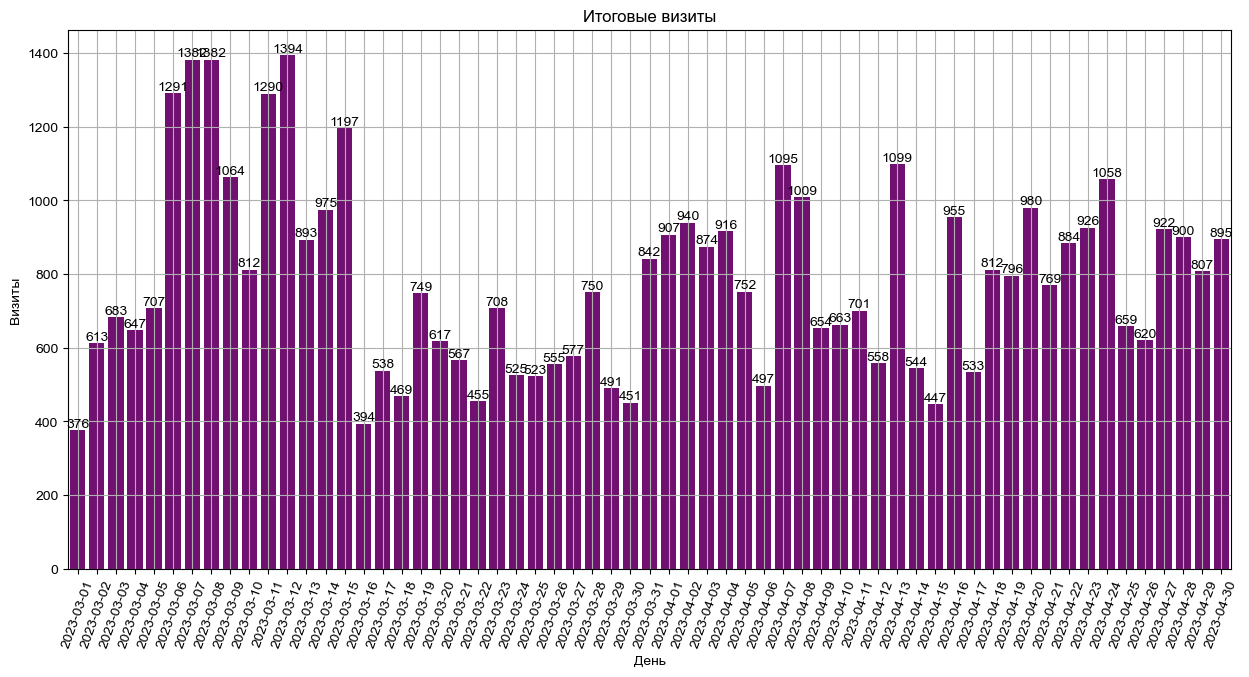

In [13]:
# Сгруппируем данные и отфильтруем датафрейм до 30.04.2023
total_visits = ads.groupby(['date_group']).agg({'visits':'sum'}).reset_index()
date_limit = datetime.strptime('2023-04-30', '%Y-%m-%d').date()
filtered_data = total_visits[total_visits['date_group'] <= date_limit]

# Построим график "Итоговые визиты" и сохраним ее
fig, ax = plt.subplots(figsize=(15, 7))
sns.barplot(x='date_group', y='visits', data=filtered_data, color='purple')
ax.bar_label(ax.containers[0], fontsize=10)
sns.set_style("white")
plt.xticks(rotation=70)
plt.xlabel('День')
plt.ylabel('Визиты')
plt.title('Итоговые визиты')
plt.grid()
plt.savefig('./charts/final_visits_chart.png')
plt.show()

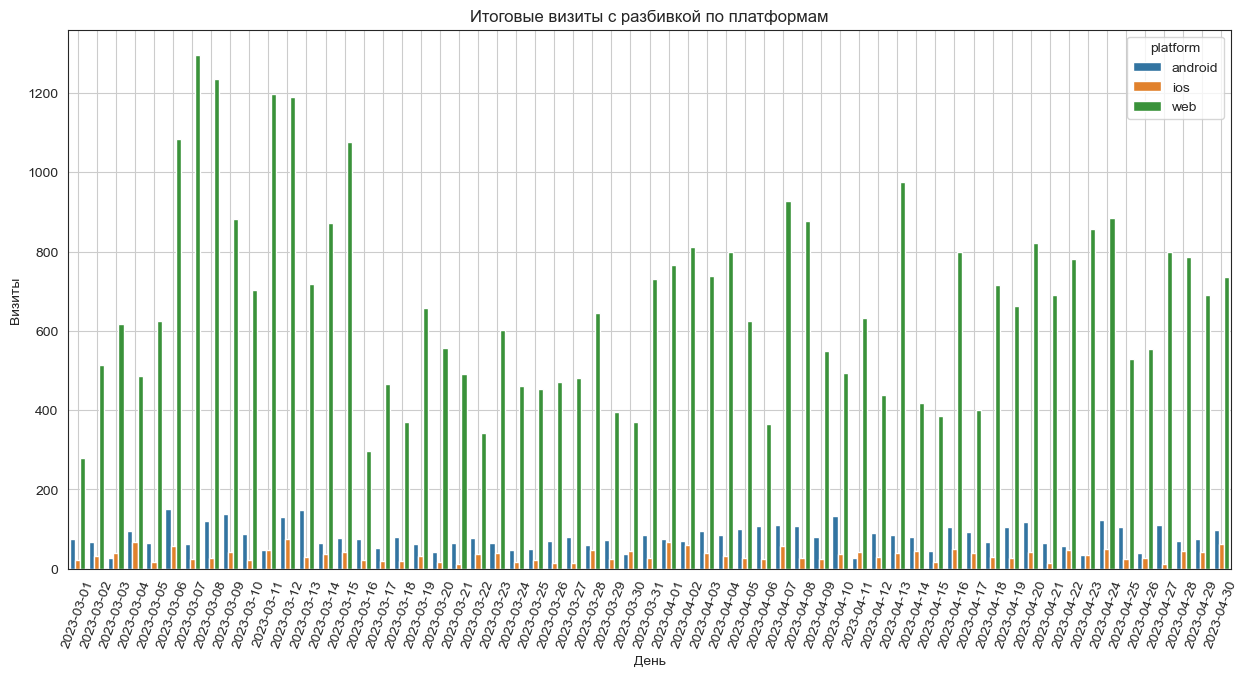

In [14]:
# Группируем и фильтруем данные по дате, платформе и суммируем количество визитов
platform_visits = ads_df.groupby(['date_group', 'platform']).agg({'visits':'sum'}).reset_index()
filtered_platform_data = platform_visits[platform_visits['date_group'] <= date_limit]

# Построим график "Итоговые визиты с разбивкой по платформам: web, android, ios"
plt.figure(figsize=(15, 7))
sns.barplot(x='date_group', y='visits', hue='platform', data=filtered_platform_data)
plt.xlabel('День')
plt.ylabel('Визиты')
plt.title('Итоговые визиты с разбивкой по платформам')
plt.xticks(rotation=70)
plt.grid()
plt.savefig('./charts/final_visits_by_platform_chart.png')
plt.show()

#### Итоговые регистрации (общие и с разбивкой по платформам)

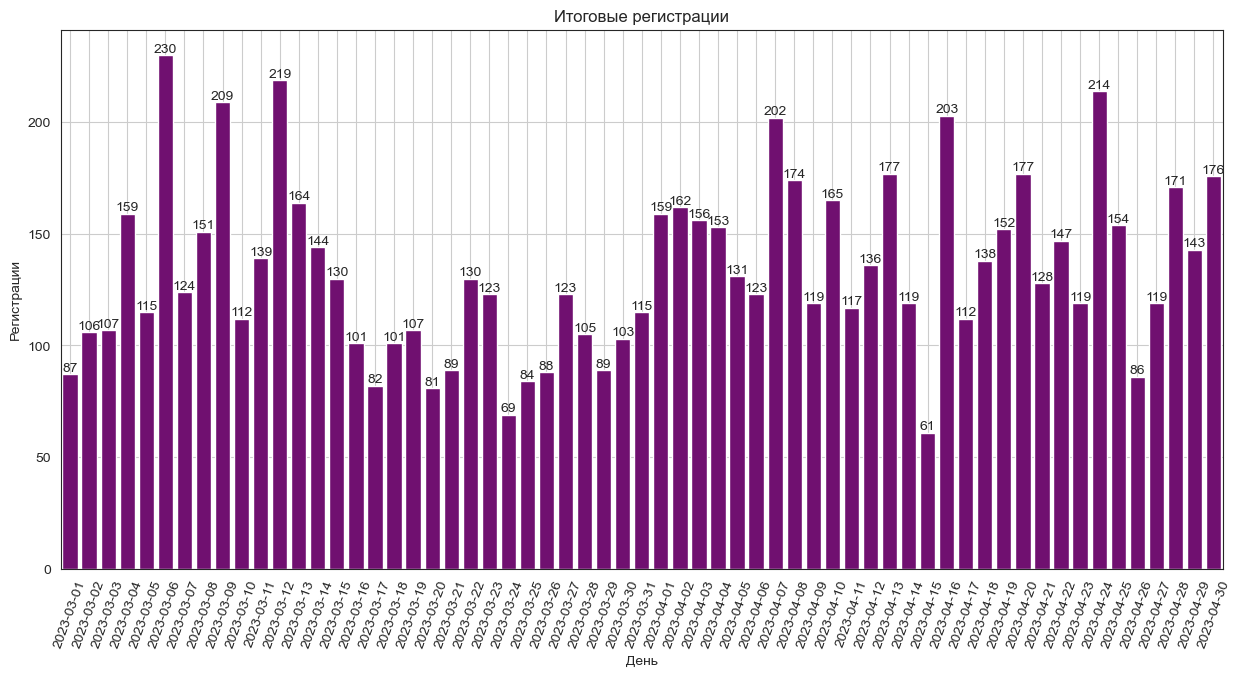

In [15]:
# Сгруппируем данные и отфильтруем датафрейм до 30.04.2023
total_registration = ads_df.groupby(['date_group']).agg({'registrations':'sum'}).reset_index()
filtered_data = total_registration[total_registration['date_group'] <= date_limit]

# Построим график "Итоговые регистрации" и сохраним ее
fig, ax = plt.subplots(figsize=(15, 7))
sns.barplot(x='date_group', y='registrations', data=filtered_data, color='purple')
ax.bar_label(ax.containers[0], fontsize=10)
# sns.set_style("white")
plt.xticks(rotation=70)
plt.xlabel('День')
plt.ylabel('Регистрации')
plt.title('Итоговые регистрации')
plt.grid()
plt.savefig('./charts/final_registrations_chart.png')
plt.show()


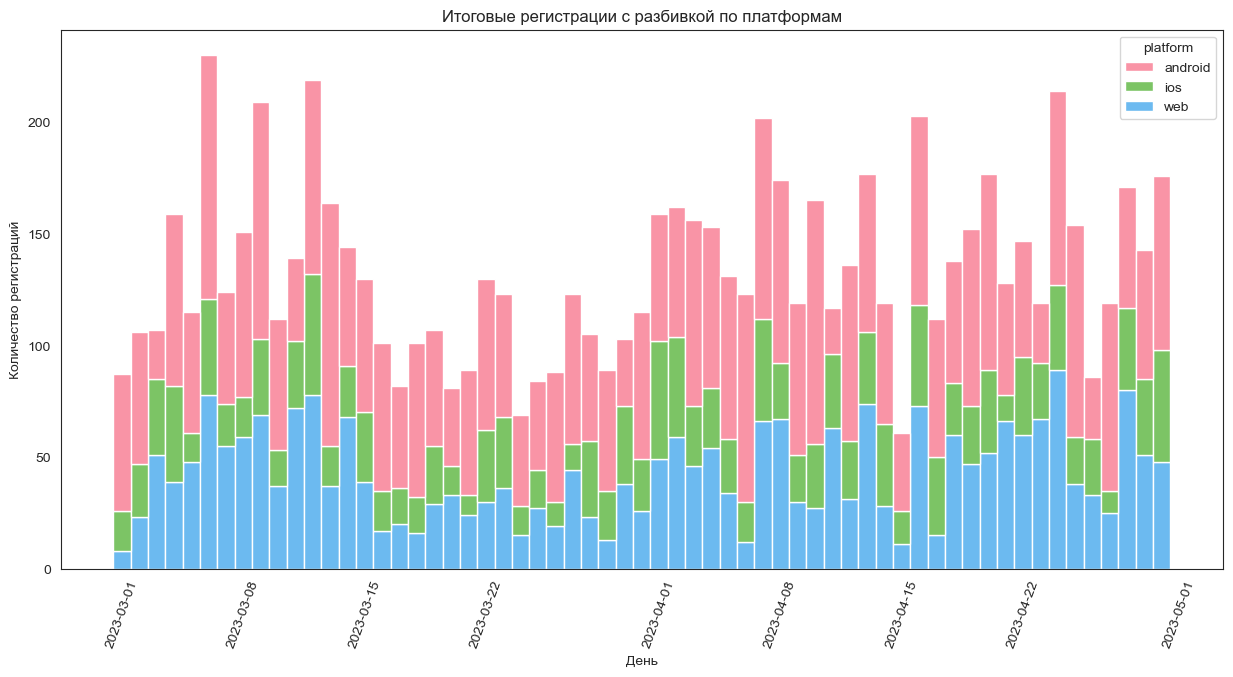

In [16]:
import warnings
import numpy as np
warnings.simplefilter(action='ignore', category=FutureWarning)
np.seterr(divide='ignore', invalid='ignore')

# Построим график "Итоговые регистрации с разбивкой по платформам: web, android, ios" и сохраним ее
fig, ax = plt.subplots(figsize=(15, 7))
sns.histplot(x='date_group', weights='registrations', hue = 'platform', data=ads_df[ads_df['date_group'] <= dt.date(2023, 4, 30)], palette = 'husl', multiple='stack')
sns.set_style("whitegrid")
plt.xticks(rotation=70)
plt.xlabel('День')
plt.ylabel('Количество регистраций')
plt.title('Итоговые регистрации с разбивкой по платформам')
plt.savefig('./charts/final_registrations_by_platform_chart.png')
plt.show()

#### Конверсия

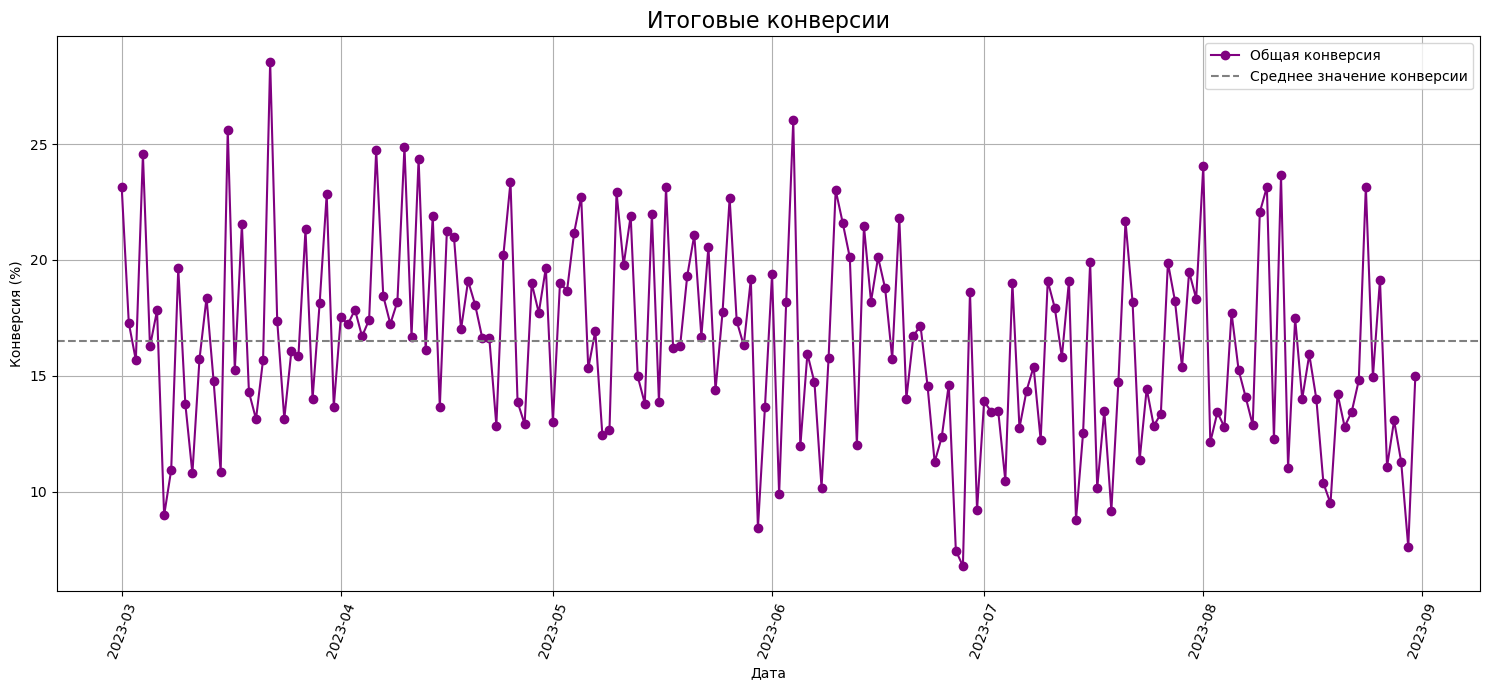

In [32]:
# Подготовим датафрейм, сгруппируем данные и отфильтруем
conversion_plt = ads_df.copy(deep=True)
conversion_plt['date_group'] = pd.to_datetime(conversion_plt['date_group'])
mean_conversion = conversion_plt.groupby('date_group').agg({'visits': 'sum', 'registrations': 'sum'})
mean_conversion['conversion'] = (mean_conversion['registrations'] / mean_conversion['visits'] * 100).round(2)
mean_conversion_all = mean_conversion['conversion'].mean()

# Построим график "Итоговые конверсии" и сохраним его
plt.figure(figsize=(15, 7))
plt.plot(mean_conversion.index, mean_conversion['conversion'], marker='o', color='purple', linestyle='-', label='Общая конверсия')
plt.axhline(y=mean_conversion_all, color='grey', linestyle='--', label='Среднее значение конверсии')
plt.title('Итоговые конверсии', fontsize=16)
plt.xlabel('Дата')
plt.ylabel('Конверсия (%)')
plt.xticks(rotation=70)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('./charts/final_conversion_chart.png')
plt.show()


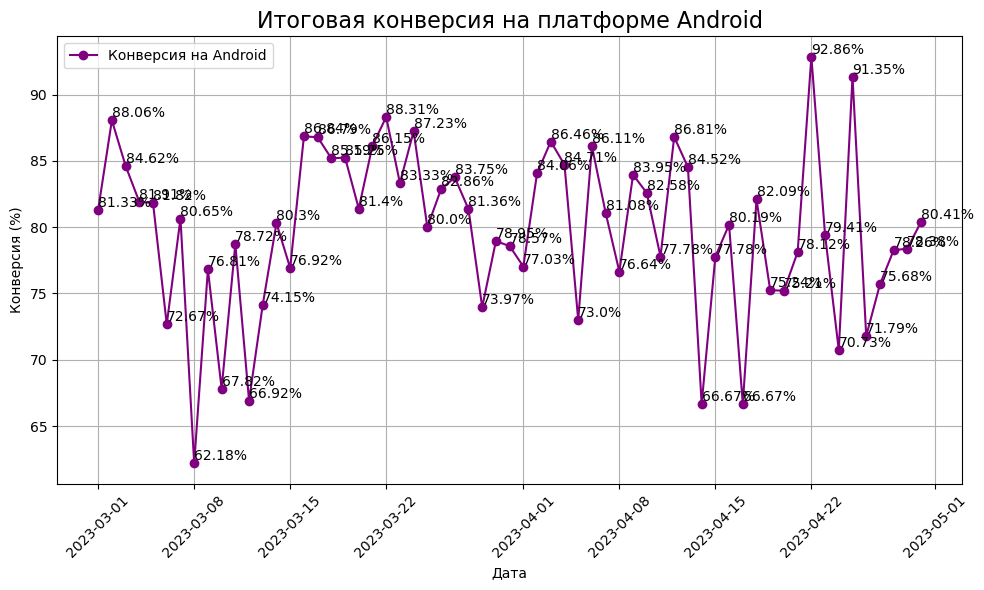

In [33]:
# Подготовим датафрейм, сгруппируем данные и отфильтруем
android_data = conversion_plt[(conversion_plt['platform'] == 'android') & (conversion_plt['date_group'] < '2023-05-01')]
android_daily_conversion = android_data.groupby('date_group')['conversion'].sum()

# Построим график "Итоговые конверсии с разбивкой по платформам: web, android, ios" и сохраним ее
# График "Итоговая конверсия на платформе Android"
plt.figure(figsize=(10, 6))
plt.plot(android_daily_conversion.index, android_daily_conversion.values, marker='o', color='purple', linestyle='-', label='Конверсия на Android')
plt.title('Итоговая конверсия на платформе Android', fontsize=16)
plt.xlabel('Дата')
plt.ylabel('Конверсия (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
for x, y in zip(android_daily_conversion.index, android_daily_conversion.values):
    plt.text(x, y, f'{y}%', ha='left', va='bottom')
plt.tight_layout()
plt.savefig('./charts/final_conversion_android_chart.png')
plt.show()

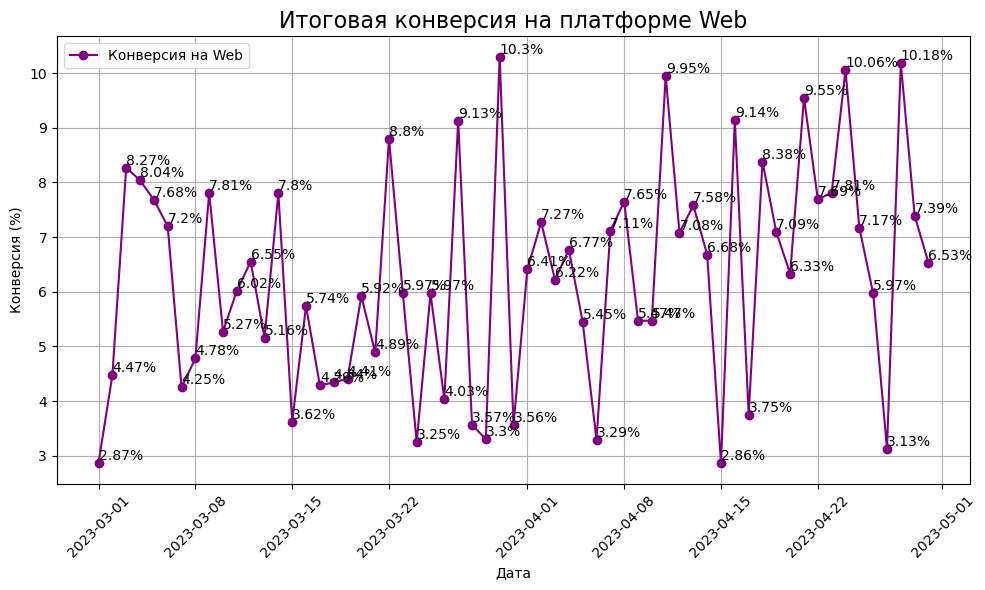

In [34]:
# Подготовим датафрейм, сгруппируем данные и отфильтруем
web_data = conversion_plt[(conversion_plt['platform'] == 'web') & (conversion_plt['date_group'] < '2023-05-01')]
web_daily_conversion = web_data.groupby('date_group')['conversion'].sum()

# Построим график "Итоговые конверсии с разбивкой по платформам: web, android, ios" и сохраним ее
# График "Итоговая конверсия на платформе Web"
plt.figure(figsize=(10, 6))
plt.plot(web_daily_conversion.index, web_daily_conversion.values, marker='o', color='purple', linestyle='-', label='Конверсия на Web')
plt.title('Итоговая конверсия на платформе Web', fontsize=16)
plt.xlabel('Дата')
plt.ylabel('Конверсия (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
for x, y in zip(web_daily_conversion.index, web_daily_conversion.values):
    plt.text(x, y, f'{y}%', ha='left', va='bottom')
plt.tight_layout()
plt.savefig('./charts/final_conversion_web_chart.png')
plt.show()

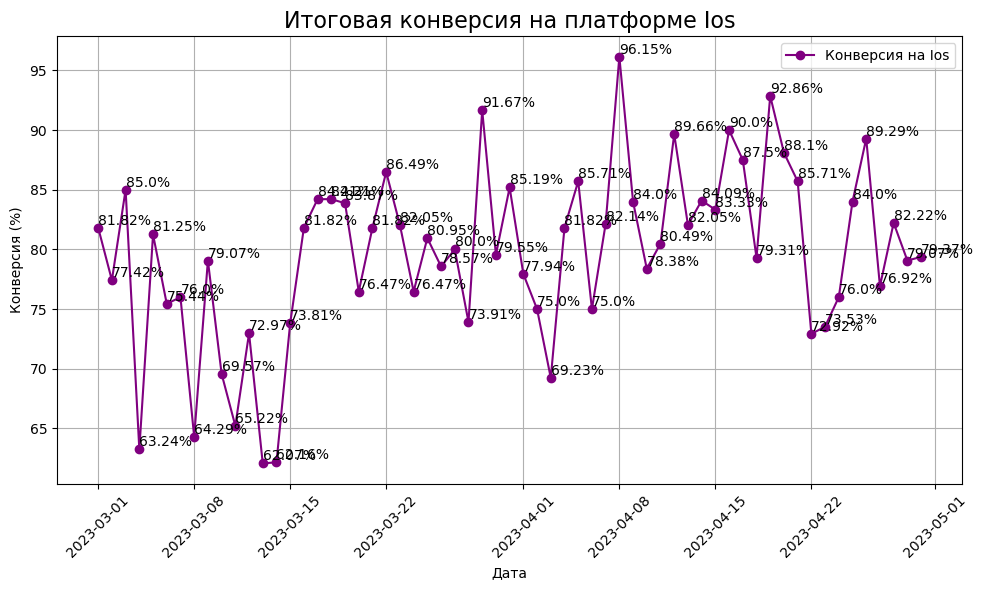

In [35]:
# Подготовим датафрейм, сгруппируем данные и отфильтруем
ios_data = conversion_plt[(conversion_plt['platform'] == 'ios') & (conversion_plt['date_group'] < '2023-05-01')]
ios_daily_conversion = ios_data.groupby('date_group')['conversion'].sum()

# Построим график "Итоговые конверсии с разбивкой по платформам: web, android, ios" и сохраним ее
# График "Итоговая конверсия на платформе Ios"
plt.figure(figsize=(10, 6))
plt.plot(ios_daily_conversion.index, ios_daily_conversion.values, marker='o', color='purple', linestyle='-', label='Конверсия на Ios')
plt.title('Итоговая конверсия на платформе Ios', fontsize=16)
plt.xlabel('Дата')
plt.ylabel('Конверсия (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
for x, y in zip(ios_daily_conversion.index, ios_daily_conversion.values):
    plt.text(x, y, f'{y}%', ha='left', va='bottom')
plt.tight_layout()
plt.savefig('./charts/final_conversion_ios_chart.png')
plt.show()

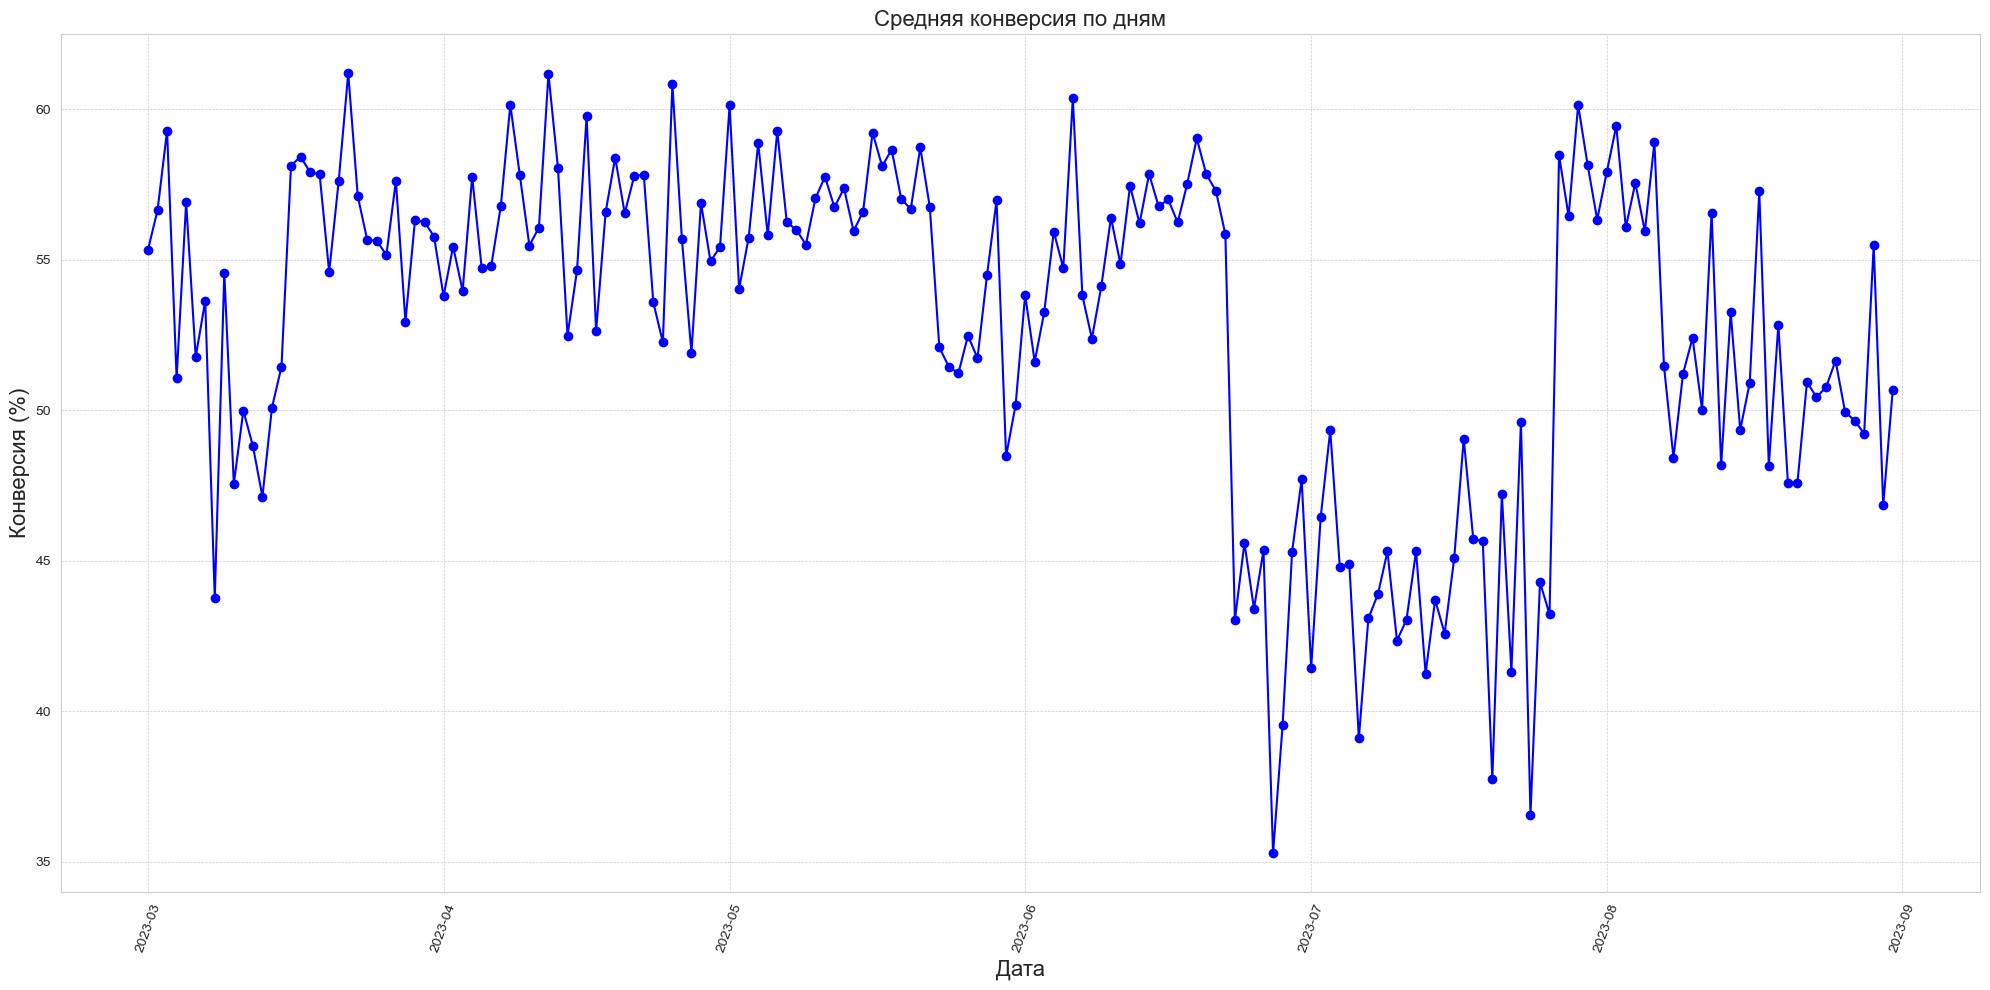

In [509]:
# Сгруппируем данные и отфильтруем 
avg_conversion = conversion_plt.groupby('date_group')['conversion'].mean()

# Построим график "Средняя конверсия" и сохраним ее
plt.figure(figsize=(20,10))
plt.plot(avg_conversion.index, avg_conversion.values, marker='o', color='b', linestyle='-')
plt.title('Средняя конверсия по дням', fontsize=16)
plt.xlabel('Дата', fontsize=16)
plt.ylabel('Конверсия (%)', fontsize=16)
plt.xticks(rotation=70)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('./charts/Average conversion_chart.png')
plt.show()

#### Реклама

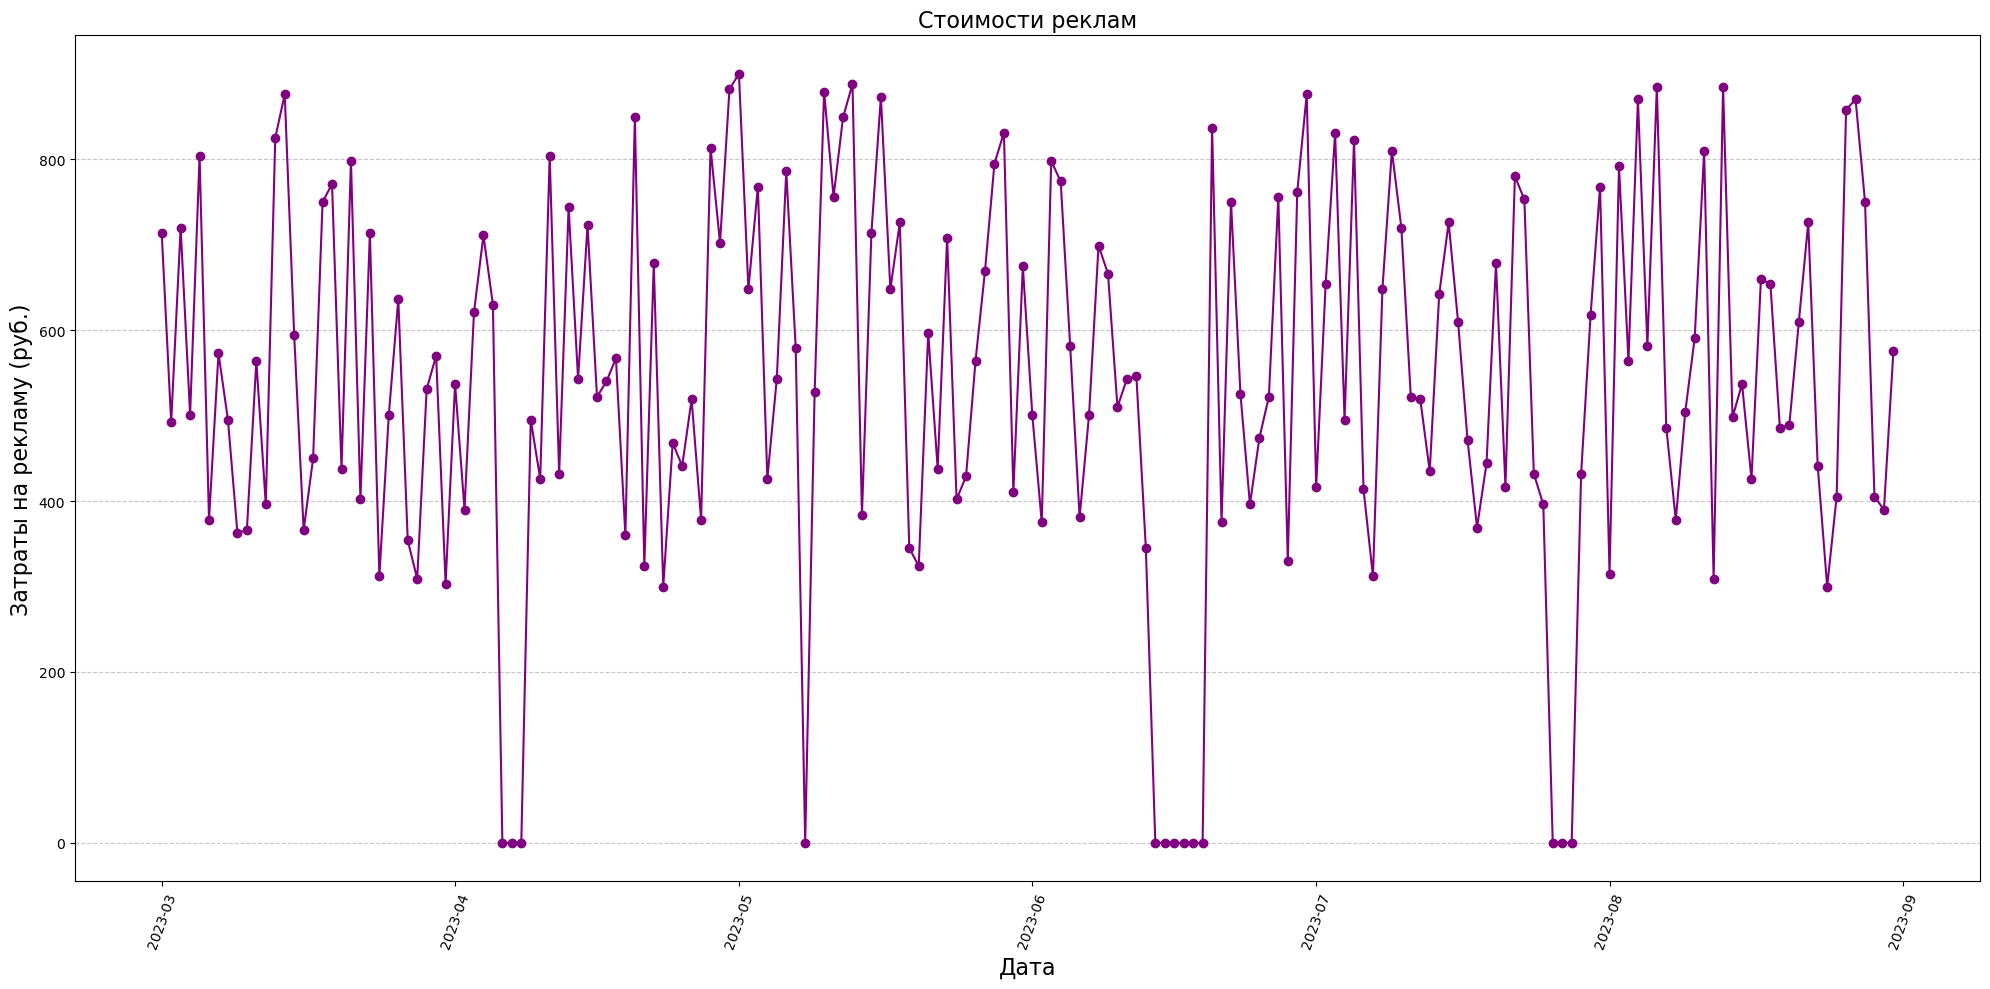

In [42]:
# Подготовим датафрейм, сгруппируем данные и отфильтруем
cost_data = ads_df.copy()
cost_data['date_group'] = pd.to_datetime(cost_data['date_group'])
cost_plt = cost_data.groupby('date_group')['cost'].sum()

# Построим график "Стоимости реклам" и сохраним ее
plt.figure(figsize=(20, 10))
# cost_plt.plot(kind='bar')
plt.plot(cost_plt.index, cost_plt.values, marker='o', color='purple', linestyle='-')
plt.title('Стоимости реклам', fontsize=16)
plt.xlabel('Дата', fontsize=16)
plt.ylabel('Затраты на рекламу (руб.)', fontsize=16)
plt.xticks(rotation=70)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('./charts/final_cost_chart.png')
plt.show()

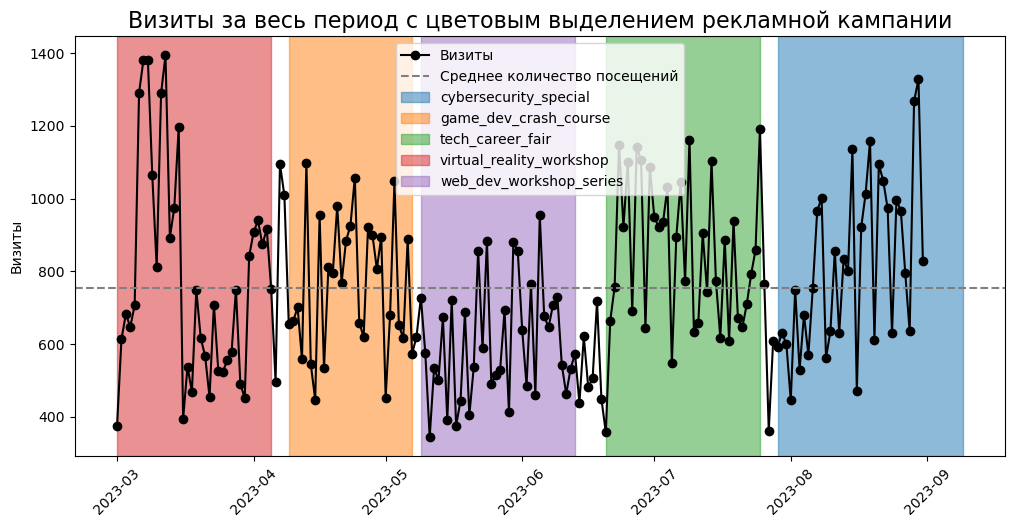

In [49]:
# Создаем датафрейм по рекламным кампаниям с периодами работы
df_cost_vr = dataframe_ads.copy()
df_cost_vr['date_group'] = pd.to_datetime(df_cost_vr['date']).dt.date
df_cost_vr = df_cost_vr.groupby(['date_group', 'utm_campaign']).agg({'utm_medium':'sum'}).reset_index()
df_cost_vr.head()

campaign_periods = df_cost_vr.groupby('utm_campaign')['date_group'].agg(['min', 'max']).reset_index()
campaign_periods.columns = ['utm_campaign', 'start', 'end']
campaign_periods = campaign_periods.sort_values(by='utm_campaign')

# Создадим условия для построения графика "Визиты за весь период с цветовым выделением рекламной кампании"
def visualize_combined_data(ads_df, campaign_periods):
    plt.figure(figsize=(12, 12))
    campaign_colors = dict(zip(campaign_periods['utm_campaign'].unique(),
                               plt.cm.tab10.colors[:len(campaign_periods['utm_campaign'].unique())]))
    plt.subplot(2, 1, 1)
    total_visits_by_date = ads_df.groupby('date_group').visits.sum().reset_index()
    plt.plot(total_visits_by_date['date_group'], total_visits_by_date['visits'], color='black', label='Визиты',
             marker='o')
    plt.axhline(y=total_visits_by_date['visits'].mean(), color='gray', linestyle='--', label="Среднее количество посещений")
    for _, row in campaign_periods.iterrows():
        plt.axvspan(row['start'], row['end'], label=row['utm_campaign'], color=campaign_colors[row['utm_campaign']], alpha=0.5)
    plt.title('Визиты за весь период с цветовым выделением рекламной кампании', fontsize=16)
    plt.ylabel('Визиты')
    plt.xticks(rotation=45)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

# Построим график и сохраним его
visualize_combined_data(cost_data, campaign_periods)
plt.savefig('./charts/Visits_during_marketing_days_chart.png')
plt.show()

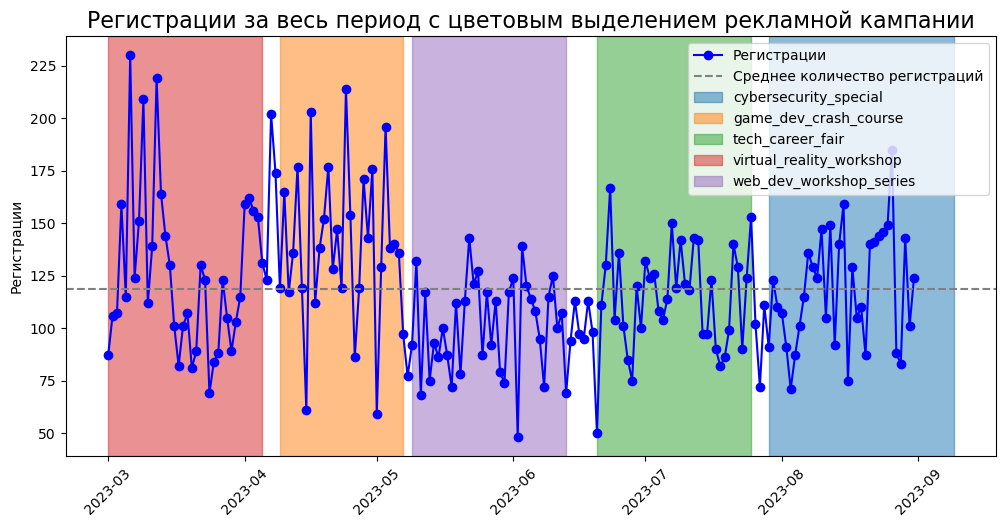

In [57]:
# Создадим условия для построения графика "Регистрации за весь период с цветовым выделением рекламной кампании"
def visualize_registrations_data(ads_df, campaign_periods):
    plt.figure(figsize=(12, 12))
    campaign_colors = dict(zip(campaign_periods['utm_campaign'].unique(),
                               plt.cm.tab10.colors[:len(campaign_periods['utm_campaign'].unique())]))
    plt.subplot(2, 1, 1)
    total_registrations_by_date = ads_df.groupby('date_group').registrations.sum().reset_index()
    plt.plot(total_registrations_by_date['date_group'], total_registrations_by_date['registrations'], color='black', label='Регистрации',
             marker='o')
    plt.axhline(y=total_registrations_by_date['registrations'].mean(), color='gray', linestyle='--', label="Среднее количество регистраций")
    for _, row in campaign_periods.iterrows():
        plt.axvspan(row['start'], row['end'], label=row['utm_campaign'], color=campaign_colors[row['utm_campaign']], alpha=0.5)
    plt.title('Регистрации за весь период с цветовым выделением рекламной кампании', fontsize=16)
    plt.ylabel('Регистрации')
    plt.xticks(rotation=45)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

# Построим график и сохраним его
visualize_registrations_data(cost_data, campaign_periods)
plt.savefig('./charts/Registrations_during_marketing_days_chart.png')
plt.show()